## MOEA/D_ALFPA


This algorithm is implemented based on <cite data-cite="moead"></cite>. The algorithm is based on [Reference Directions](../misc/reference_directions.ipynb) which need to be provided when initializing the algorithm object.

In [121]:
import math
import numpy as np
from scipy.spatial.distance import cdist

from pymoo.algorithms.so_cuckoo_search import MantegnasAlgorithm
from pymoo.decomposition.pbi import PBI
from pymoo.docs import parse_doc_string
from pymoo.model.algorithm import Algorithm
from pymoo.model.duplicate import DefaultDuplicateElimination
from pymoo.model.initialization import Initialization
from pymoo.model.population import Population
from pymoo.operators.repair.to_bound import set_to_bounds_if_outside
from pymoo.operators.sampling.random_sampling import FloatRandomSampling
from pymoo.util.termination.default import MultiObjectiveDefaultTermination
from pymoo.util.misc import has_feasible
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

class AdaptiveLevyFlight:
    def __init__(self, alpha, beta, do_all=True):
        self.alpha = alpha
        #beta must be in range of [1..2]
        beta = min(beta, 2)
        beta = max(beta, 1)
        self.beta = beta            
        self.cauchy = np.random.default_rng().standard_cauchy
        self.gaussian = np.random.default_rng().standard_normal        
        self.do_all = True
        if do_all:
            self.levy1 = MantegnasAlgorithm(1.3) 
            self.levy2 = MantegnasAlgorithm(1.7)
        else:
            self.levy = MantegnasAlgorithm(beta)        

    def _do_all(self, xbest, xi, xl, xu):
        cstep = self.cauchy(len(xi))
        lstep1 = self.levy1.do(len(xi))
        lstep2 = self.levy2.do(len(xi))
        gstep = self.gaussian(len(xi))
        steps = np.array([cstep, lstep1, lstep2, gstep])
        direction = xbest-xi
        scale = xu-xl
        _X = xi + direction*scale*steps
        _X = set_to_bounds_if_outside(_X, xl, xu)
        return Population.new(X=_X)
    
    def _do(self, xbest, xi, xl, xu):
        
        if self.do_all:
            return self._do_all(xbest, xi, xl, xu)
        
        # get random levy values to be used for the step size
        if beta == 1:
            levy = self.cauchy(len(xi))
        elif beta == 2:
            levy = self.normal(len(xi))
        else:
            levy = self.levy.do(len(xi))
        direction = (xbest-xi)
        _x = xi + (xu - xl)*self.alpha * levy * direction
        _x = set_to_bounds_if_outside(_x, xl, xu)

        return Population.new(X=_x[None, :])

class MOEAD_ALFPA(Algorithm):

    def __init__(self,
                 ref_dirs,
                 sampling=FloatRandomSampling(),
                 eliminate_duplicates=DefaultDuplicateElimination(),
                 termination=MultiObjectiveDefaultTermination(),
                 decomposition=PBI(),
                 adaptive=False,
                 archive_size=100,
                 n_neighbors=None,
                 n_replacement=3,                 
                 alpha=0.01,
                 p=0.8,
                 pa=0.8,
                 **kwargs):
        """

        Parameters
        ----------
        display : {display}
        sampling : {sampling}
        survival : {survival}
        eliminate_duplicates: This does not exists in the original paper/book.
            Without this the solutions might get too biased to current global best solution,
            because the global random walk use the global best solution as the reference.

        termination : {termination}

        pop_size : The number of nests (solutions)

        beta : The input parameter of the Mantegna's Algorithm to simulate
            sampling on Levy Distribution

        alfa : alfa is the step size scaling factor and is usually
            0.01, so that the step size will be scaled down to O(L/100) with L is
            the scale (range of bounds) of the problem.

        pa   : The switch probability
        """

        super().__init__(**kwargs)
        
        #prepare operators
        self.adaptive = adaptive
        if not adaptive:
            self.grw = AdaptiveLevyFlight(alpha, 0, do_all=True)
        else:
            cauchy = AdaptiveLevyFlight(alpha, 1, do_all=False)
            levy1 = AdaptiveLevyFlight(alpha, 1.3, do_all=False)
            levy2 = AdaptiveLevyFlight(alpha, 1.7, do_all=False)
            gaussian = AdaptiveLevyFlight(alpha, 2, do_all=False)
            self.mating = [cauchy, levy1, levy2, gaussian]

        self.initialization = Initialization(sampling)        
        self.default_termination = termination
        self.eliminate_duplicates = eliminate_duplicates
        self.decomposition = decomposition
        self.nds = NonDominatedSorting()  
        
        self.archive_size = archive_size
        self.ref_dirs = ref_dirs
        self.pop_size = len(ref_dirs)
        #prepare neighbours list
        #neighbours includes the entry by itself intentionally for the survival method
        self.n_neighbors = n_neighbors
        if n_neighbors is None:
            self.n_neighbors = int(0.1*self.pop_size)
        self.neighbors_list = np.argsort(cdist(self.ref_dirs, self.ref_dirs), axis=1, kind='quicksort')
        self.neighbors_list = self.neighbors_list[:, :self.n_neighbors]
                
        #the scale will be multiplied by problem scale after problem given in setup                
        self.alpha = alpha
        self.p = p
        self.pa = pa
        self.n_replacement = n_replacement          
       
        #prepare external archive
        self.ideal_point = []        
        
        
    def _initialize(self):
        pop = self.initialization.do(self.problem,
                                     self.pop_size,
                                     algorithm=self,
                                     eliminate_duplicates=self.eliminate_duplicates)
        self.evaluator.eval(self.problem, pop, algorithm=self)
        self.pop = pop
        self.opt = pop
        self.ideal_point = np.min(self.pop.get("F"), axis=0)

    def _set_optimum(self, **kwargs):
        self.opt = Population.merge(self.pop, self.opt)
        non_dominated_idx = self.nds.do(self.opt.get("F"), return_rank=True, only_non_dominated_front=True)
        self.opt = self.opt[non_dominated_idx][:self.archive_size]    
        print(len(self.opt))
    
    def _lrw(self, X, xi, xl, xu, n_offsprings):
        #find n_offsprings*2 different solutions (n_offsprings pair) 
        Pair = np.random.permutation(X)[:2*n_offsprings]
        R1, R2 = Pair[:n_offsprings], Pair[n_offsprings:2*n_offsprings]
        r = np.tile(np.random.rand(n_offsprings), (self.problem.n_var, 1)).T
        _X = xi + r*(R1-R2)
        _X = set_to_bounds_if_outside(_X, xl, xu)
        return Population.new(X=_X)
        
    def _next(self):
        xl, xu = self.problem.bounds()
        pop_idx_permutation = np.random.permutation(self.pop_size)
        X = self.pop.get("X")
        F = self.pop.get("F")
        Xopt = self.opt.get("X")
        for idx in pop_idx_permutation:                        
            xi = X[idx]            
            #choose current neighbourhood wether from ref neighbors or from all population
            #N = neighborhood
            if np.random.rand() < self.p:
                N = self.neighbors_list[idx]
            else:
                N = np.arange(self.pop_size)
                
            #permute the N so that they have fair chance to be updated (because)
            #the number of improvement is limited
            N = np.random.permutation(N)
            #choose operator either adaptive Levy or local random walk
            if np.random.rand() < self.pa:
                #Do Global Pollination by adaptive levy                                        
                #get 1 random best from archive (nondominated solutions)
                xbest = self.opt.get("X")
                xbest = xbest[np.random.permutation(len(self.opt))[:4]]
                if not self.adaptive:
                    off = self.grw._do(xbest, xi, xl, xu)                
            else:
                #Do local Polination
                off = self._lrw(X, xi, xl, xu, 4)
                        
            #evaluate and update ideal value
            self.evaluator.eval(self.problem, off)
            _F = off.get("F")
            _X = off.get("X")
            self.ideal_point = np.min(np.vstack([self.ideal_point, _F]), axis=0)

            # calculate the decomposed values for each neighbor
            rho = self.alpha**self.problem.n_var
            FV = self.decomposition.do(F[N], weights=self.ref_dirs[N, :], ideal_point=self.ideal_point, rho=rho)
            off_FV = self.decomposition.do(_F, weights=self.ref_dirs[N, :], ideal_point=self.ideal_point, rho=rho)
            
            #get the best candidate of offspring for each ref_dirs
            off_FV_idx = np.argmin(off_FV, axis=0)
            off_FV = np.min(off_FV, axis=0)
            
            #update some of the neighbours, if the new solution is better
            #limited to number of replacement n_replacement
            improved = off_FV < FV            
            off_FV_idx = off_FV_idx[improved][:self.n_replacement]            
            X[off_FV_idx] = _X[off_FV_idx]
            F[off_FV_idx] = _F[off_FV_idx]
        
        #loop ends
        #not "get"ting too many times in the loop because it's costly
        self.pop.set("X", X)
        self.pop.set("F", F)
#         print(self.n_gen)

parse_doc_string(MOEAD_ALFPA.__init__)

30
43
59
70
61
74
88
100
100
100
100
100
100
100
100
100
83
60
71
85
95
42
38
47
61
75
87
96
100
100
100
90
100
100
100
97
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
86
99
100
100
81
94
100
100
63
73
68
82
95
100
100
100
100
93
100
100
100
100
91
100
100
95
100
100
97
100
100
100
69
82
97
100
100
100
78
83
86
100
100
100
100
69
58
72
84
97
100
100
100
100
100
100
100
100
98
100
79
92
100
100
100
100
100
100
100
100
100
97
100
100
100
97
100
100
100
100
100
100
100
91
100
100
100
91
100
100
81
93
100
100
100
100
100
98
100
100
89
100
100
100
100
100
100
100
100
100
100
72
84
97
100
100
100
100
100
100
100
87
91
87
100
100
90
100
86
98
100
100
100
100
58
70
85
98
97
80
92
100
100
100
99
100
100
100
94
18.48575210571289


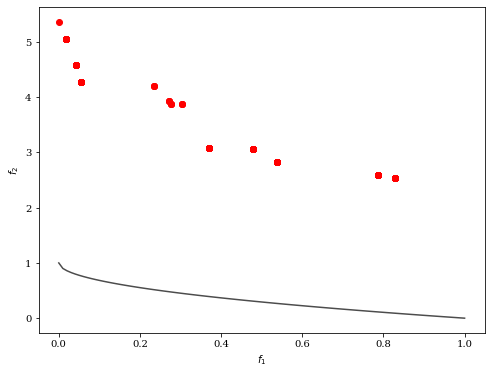

In [123]:
from pymoo.factory import get_problem, get_visualization, get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.decomposition.perp_dist import PerpendicularDistance

problem = get_problem("zdt1")
n_obj = 2
ref_generating_method = "das-dennis"
ref_dirs = get_reference_directions(ref_generating_method, n_obj, n_partitions=99)

algorithm = MOEAD_ALFPA(ref_dirs=ref_dirs)
res = minimize(problem, algorithm, termination=('n_gen', 200))
print(res.exec_time)
if n_obj == 2:
    plot = Scatter()
    plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
    plot.add(res.F, color="red")
    plot.show()
else:
    plot = Scatter().add(res.F)
    plot.show()
    


### API